<a href="https://colab.research.google.com/github/vondervish/Emotion_Detection_Roberta/blob/main/Assignment8_Qwen_inst_Exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <font color = 'indianred'>**Multilabel Classification of Emotion Dataset using Qwen- Instruction model** </font>


In [ ]:
import torch
print(torch.__version__)

2.5.1+cu121


In [ ]:
!python --version

Python 3.10.12


# <font color = 'indianred'> **1. Setting up the Environment** </font>

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes trl fsspec -U  -qq

    basepath = '/content/drive/MyDrive/Data'

else:
    basepath = '/C:/Users/Vishu/Downloads/Fall_2024/App_NLP'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.3/336.3 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
ERROR: pip'

In [ ]:
# standard pythgion libraries
from pathlib import Path
import re
import gc
import time
from typing import Dict, List, Union, Optional, Tuple
from tqdm import tqdm
import itertools
import json
import joblib
import ast
from datetime import datetime
from difflib import get_close_matches
import os
import sys

# Data Science librraies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

# Pytorch
import torch
import torch.nn as nn

# Huggingface Librraies
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
    AutoPeftModelForCausalLM,
    PeftConfig
)

from huggingface_hub import login

# Logging and secrets
import wandb
from google.colab import userdata

In [ ]:
set_seed(42)

In [ ]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')

In [ ]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")

Successfully logged in to Hugging Face!


In [ ]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vondervish (vondervish-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [ ]:
base_folder = Path(basepath)
data_folder = base_folder/'emotion-detection-bert-fall-2024'
model_folder = base_folder/'Models/Emotion_detection_Qwen_instruct_fall_2024'

In [ ]:
model_folder.mkdir(exist_ok=True, parents = True)

In [ ]:
model_folder

PosixPath('/content/drive/MyDrive/Data/Models/Emotion_detection_Qwen_instruct_fall_2024')

# <font color = 'indianred'> **2. Load Data set**

In [ ]:
train_dataset = data_folder/'train.csv'
test_dataset = data_folder/'test.csv'

In [ ]:
from datasets import load_dataset

# Load the train and test datasets from CSV files
train_dataset = load_dataset('csv', data_files={'train': str(data_folder / 'train.csv')})['train']
test_dataset = load_dataset('csv', data_files={'test': str(data_folder / 'test.csv')})['test']

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
    num_rows: 7724
})

In [ ]:
class_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>

In [ ]:
# Split train_dataset into a new train and validation set
train_val_split = train_dataset.train_test_split(test_size=0.2, seed=42)

# Assign the splits to new variables
train_dataset = train_val_split['train']
valid_dataset = train_val_split['test']

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 81.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 7.6 MB/s eta 0:00:00


In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.2 MB/s eta 0:00:00


In [ ]:
!pip install textblob
!pip install emot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.5 MB/s eta 0:00:00


In [ ]:
import spacy
from bs4 import BeautifulSoup
import re
import emoji
import contractions
from textblob import TextBlob
import emot

# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Dictionary for expanding common slang
slang_dict = {
    "omg": "oh my god",
    "lol": "laugh out loud",
    "brb": "be right back",
    "smh": "shaking my head"
}

# Emoticons to emotion mapping
emoticons = emot.emo_unicode.EMOTICONS_EMO

# Function to reduce elongated words (e.g., "soooo" -> "soo")
def reduce_elongation(text):
    return re.sub(r'(.)\1+', r'\1\1', text)  # Reduces "soooo" to "soo"

# Function to expand slang terms using a dictionary
def expand_slang(text):
    return ' '.join([slang_dict.get(word, word) for word in text.split()])

# Function to handle negations (e.g., "not happy" -> "not_happy")
def handle_negations(text):
    words = text.split()
    new_words = []
    negation = False
    for word in words:
        if word in ['not', 'no', 'never']:
            negation = True
        elif negation:
            new_words.append(f'not_{word}')
            negation = False
        else:
            new_words.append(word)
    return ' '.join(new_words)

# Main function for cleaning the text
def clean_for_emotion(text: str) -> str:
    # Step 1: Remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    # Step 2: Normalize newlines and return characters
    text = re.sub(r'[\n\r]', ' ', text)

    # Step 3: Lowercase the text
    text = text.lower()

    # Step 4: Remove URLs and mentions
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions

    # Step 5: Remove special characters but keep punctuations like !, ?, $, %, /
    text = re.sub(r'[^\w\s!?$%/]', '', text)

    # Step 6: Expand contractions (e.g., "don't" -> "do not")
    text = contractions.fix(text)

    # Step 7: Expand slang (e.g., "lol" -> "laugh out loud")
    text = expand_slang(text)

    # Step 8: Handle elongated words (e.g., "soooo" -> "soo")
    text = reduce_elongation(text)

    # Step 9: Convert emojis to text using emoji library
    text = emoji.demojize(text)

    # Step 10: Convert emoticons to text (e.g., ":)" -> "happy")
    for emoticon, emotion in emoticons.items():
        text = text.replace(emoticon, emotion)


    # Step 12: Handle negations (e.g., "not happy" -> "not_happy")
    text = handle_negations(text)

    # Step 13: Remove excessive spaces
    text = re.sub(' +', ' ', text).strip()

    return text

In [ ]:
print(type(train_dataset))  # Expected to be `datasets.Dataset`
print(type(valid_dataset))  # Expected to be `datasets.Dataset`
print(type(test_dataset))   # Expected to be `datasets.Dataset`

<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>


In [ ]:
train_val_dataset= DatasetDict(
    {"train": train_dataset, "valid": valid_dataset})

In [ ]:
# Apply the cleaning function using .map() on each split
train_val_dataset = train_val_dataset.map(lambda x: {'Tweet': clean_for_emotion(x['Tweet'])},
                                          batched=False)

# Also apply the cleaning function to the test dataset
test_dataset = test_dataset.map(lambda x: {'Tweet': clean_for_emotion(x['Tweet'])},
                                batched=False)

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

<ipython-input-21-074558393167>:49: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
train_val_dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 1545
    })
})

In [ ]:
# Function to reformat a single dataset
def reformat_dataset(dataset):
    # Map each row to extract the label and keep only relevant columns
    def format_row(row):
        # Collect emotions where the value is 1
        labels = [emotion for emotion in class_names if row[emotion] == 1]
        return {"text": row["Tweet"], "label": labels}

    # Apply the transformation
    return dataset.map(format_row, remove_columns=["ID"] + class_names)

# Reformat both train and validation datasets separately
train_val_dataset = DatasetDict({
    "train": reformat_dataset(train_val_dataset["train"]),
    "valid": reformat_dataset(train_val_dataset["valid"])
})

# Display a sample from the train dataset
print(train_val_dataset["train"][0])

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

{'Tweet': 'does anyone know are both sims in a dual sim phone both locked to the same network! worry', 'text': 'does anyone know are both sims in a dual sim phone both locked to the same network! worry', 'label': ['fear', 'pessimism', 'sadness']}


In [ ]:
# Define columns to keep
selected_columns = ['text', 'label']

# Remove other columns in train and valid sets within train_val_dataset
train_val_dataset['train'] = train_val_dataset['train'].remove_columns(
    [col for col in train_val_dataset['train'].column_names if col not in selected_columns])

train_val_dataset['valid'] = train_val_dataset['valid'].remove_columns(
    [col for col in train_val_dataset['valid'].column_names if col not in selected_columns])

# Remove other columns in test_dataset
test_dataset = test_dataset.remove_columns(
    [col for col in test_dataset.column_names if col not in selected_columns])

In [ ]:
train_val_dataset['train'][1]

{'text': 'a not_very young man compiled info on a smiling baby then a mattress created new evil',
 'label': ['anger', 'anticipation', 'joy']}

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>

In [ ]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
checkpoint = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [ ]:
tokenizer.eos_token

'<|im_end|>'

In [ ]:
tokenizer.pad_token

'<|endoftext|>'

In [ ]:
tokenizer.padding_side

'right'

In [ ]:
tokenizer.chat_template

'{%- if tools %}\n    {{- \'<|im_start|>system\\n\' }}\n    {%- if messages[0][\'role\'] == \'system\' %}\n        {{- messages[0][\'content\'] }}\n    {%- else %}\n        {{- \'You are Qwen, created by Alibaba Cloud. You are a helpful assistant.\' }}\n    {%- endif %}\n    {{- "\\n\\n# Tools\\n\\nYou may call one or more functions to assist with the user query.\\n\\nYou are provided with function signatures within <tools></tools> XML tags:\\n<tools>" }}\n    {%- for tool in tools %}\n        {{- "\\n" }}\n        {{- tool | tojson }}\n    {%- endfor %}\n    {{- "\\n</tools>\\n\\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\\n<tool_call>\\n{\\"name\\": <function-name>, \\"arguments\\": <args-json-object>}\\n</tool_call><|im_end|>\\n" }}\n{%- else %}\n    {%- if messages[0][\'role\'] == \'system\' %}\n        {{- \'<|im_start|>system\\n\' + messages[0][\'content\'] + \'<|im_end|>\\n\' }}\n    {%- else %}\n       

#<font color = 'indianred'> **5. Create Prompts**

In [ ]:
class_names

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [ ]:
def format_chat(example):
    instruction = f"Classify the TEXT by selecting all applicable labels from the following list: {class_names}.\n\nTEXT: {example['text']}"
    messages = [
        {"role": "user", "content": instruction},
        {"role": "assistant", "content": f"{example['label']}"}
    ]
    return {"text": tokenizer.apply_chat_template(messages, tokenize=False)}

In [ ]:
train_val_dataset_chat = train_val_dataset.map(format_chat)

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
train_val_dataset_chat

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1545
    })
})

In [ ]:
train_val_dataset_chat['train'][0]

{'text': "<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: does anyone know are both sims in a dual sim phone both locked to the same network! worry<|im_end|>\n<|im_start|>assistant\n['fear', 'pessimism', 'sadness']<|im_end|>\n",
 'label': ['fear', 'pessimism', 'sadness']}

In [ ]:
train_val_dataset_chat['valid'][0]

{'text': "<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: hi monica i write regularly for but not_on bees not_dared try them buzz honey<|im_end|>\n<|im_start|>assistant\n['joy']<|im_end|>\n",
 'label': ['joy']}

##  <font color = 'indianred'> **5.1 Filter Longer sequences**

In [ ]:
def check_length(example):
   encoding = tokenizer.encode(example['text'])
   return len(encoding) <= 1000

train_filtered = train_val_dataset_chat['train'].filter(check_length)
valid_filtered = train_val_dataset_chat['valid'].filter(check_length)

print(f"Train: {len(train_val_dataset_chat['train'])} -> {len(train_filtered)}")
print(f"Valid: {len(train_val_dataset_chat['valid'])} -> {len(valid_filtered)}")

Filter:   0%|          | 0/6179 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1545 [00:00<?, ? examples/s]

Train: 6179 -> 6179
Valid: 1545 -> 1545


#  <font color = 'indianred'> **6. Model Training**

##  <font color = 'indianred'> **6.1 Download pre-trained model**

In [ ]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [ ]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [ ]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [ ]:
model_qwen_instruct = AutoModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,)

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

##  <font color = 'indianred'> **6.2 PEFT Setup**

In [ ]:
model_qwen_instruct

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear4bit(in_features=896, out_features=896, bias=True)
          (k_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (v_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (o_proj): Linear4bit(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear4bit(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    

In [ ]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [ ]:
find_linear_layers(model_qwen_instruct)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'lm_head']


['down_proj',
 'lm_head',
 'q_proj',
 'k_proj',
 'gate_proj',
 'v_proj',
 'up_proj',
 'o_proj']

In [ ]:
TaskType.CAUSAL_LM

<TaskType.CAUSAL_LM: 'CAUSAL_LM'>

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=128,
    lora_alpha=256,
    lora_dropout=0.1,
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model_qwen_instruct, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 70,385,664 || all params: 564,418,432 || trainable%: 12.4705


## <font color = 'indianred'> **6.3 Training Arguments**</font>

In [ ]:
run_name= 'qwen_qlora_inst'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = SFTConfig(
    max_seq_length= 1024,
    seed = 42,
    dataset_text_field="text",

    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=4,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)

In [ ]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    model_qwen_instruct.config.use_cache = False  # Disable caching for compatibility

model_qwen_instruct.config

Qwen2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "Qwen/Qwen2.5-0.5B-Instruct",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 21,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_n

##  <font color = 'indianred'> **6.4 Initialize Trainer**</font>

In [ ]:
data_collator_comp = DataCollatorForCompletionOnlyLM(tokenizer=tokenizer, mlm=False,
                                                      response_template="<|im_start|>assistant\n")
trainer = SFTTrainer(
    model=model_qwen_instruct,
    args=training_args,
    train_dataset=train_filtered,
    eval_dataset=valid_filtered,

    peft_config=peft_config,
    packing=False,
    data_collator=data_collator_comp,

)

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
%env WANDB_PROJECT = Emotion_detection_fall_2024

env: WANDB_PROJECT=Emotion_detection_fall_2024


In [ ]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e

Step,Training Loss,Validation Loss
20,0.469700,0.386605
40,0.374600,0.358075
60,0.336100,0.341461
80,0.319800,0.332343
100,0.318200,0.328102
120,0.320300,0.334235
140,0.335600,0.322589
160,0.316400,0.319290
180,0.316200,0.309636
200,0.320800,0.311843


In [ ]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]

In [ ]:
best_model_checkpoint_step

'380'

In [ ]:
model_folder = base_folder/'Models/Emotion_detection_Qwen_instruct_fall_2024'
best_model_checkpoint_step
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.padding_side = 'left'

In [ ]:
def format_chat_inference(example):
    instruction = f"Classify the TEXT by selecting all applicable labels from the following list: {class_names}.\n\nTEXT: {example['text']}"
    messages = [
        {"role": "user", "content": instruction},
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return {"text": text}

In [ ]:
valid_dataset= train_val_dataset['valid'].map(format_chat_inference)

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
valid_filtered = valid_dataset.filter(check_length)

Filter:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
valid_filtered['text'][0]

"<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: hi monica i write regularly for but not_on bees not_dared try them buzz honey<|im_end|>\n<|im_start|>assistant\n"

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
def run_inference_instruction(
    seed: int,
    dataset: Union[Dict, List],
    model,
    tokenizer,
    per_device_batch_size: int,
    input_field: str,
    output_field: str,
    save_dir: Optional[Path] = None,
    save_file_name: Optional[str] = None,
    max_new_tokens: int = 25,
    num_beams: int = 1,
    do_sample: bool = False,
    top_k: int = 50,
    top_p: float = 1.0,
    temperature: float = 1.0,
    no_repeat_ngram_size: int = 2,
    num_return_sequences: int = 1
) -> List[Dict]:

    """
    Run inference on a dataset and return complete generations.

    Args:
        seed: Random seed for reproducibility
        dataset: Input dataset (dict or list)
        model: The model to use for inference
        tokenizer: The tokenizer to use
        per_device_batch_size: Batch size for inference
        prompt_template: Template for formatting prompts
        input_field: Field name for input text in dataset
        output_delimiter: Delimiter used in prompt template
        save_path: Optional path to save generations
        ... (generation parameters)

    Returns:
        List of dictionaries containing input, complete generation, and labels
    """

    set_seed(seed)
    model.eval()
    device = model.device
    batch_size = per_device_batch_size
    inference_results = []


    progress_bar = tqdm(range(0, len(dataset), batch_size), desc="Generating predictions")

    for i in progress_bar:
       batch = dataset[i:i + batch_size]

       try:
           texts = batch[input_field]
           labels = batch[output_field] if output_field in batch else ["N/A"] * len(texts)


           inputs = tokenizer(texts, return_tensors="pt", padding=True)
           inputs = {k: v.to(device) for k, v in inputs.items()}

           with torch.no_grad():
               outputs = model.generate(
                   **inputs,
                   max_new_tokens=max_new_tokens,
                   num_beams=num_beams,
                   do_sample=do_sample,
                   top_k=top_k,
                   top_p=top_p,
                   temperature=temperature,
                   pad_token_id=tokenizer.pad_token_id,
               )

           decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=False)

           for text, label, decoded_output in zip(texts, labels, decoded_outputs):
                   inference_results.append({
                    "input": text,
                    "generated_output": decoded_output,
                    "ground_truth": label
                })


       except Exception as e:
           print(f"Error processing batch: {str(e)}")
           continue
    # Save generations if path provided
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        # If no filename provided, create a timestamped one
        if save_file_name is None:
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_name = f"generations_{timestamp}.json"
        elif not save_file_name.endswith('.json'):
            save_name = f"{save_file_name}.json"

        save_file = save_dir / save_name

        with open(save_file, 'w') as f:
            json.dump(inference_results, f, indent=2)
        print(f"Saved inference_results to: {save_file}")

    return inference_results

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
valid_inference_results = run_inference_instruction(seed = 42,
              dataset=valid_filtered,
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=50,
              input_field='text',
              output_field='label',
              save_dir=model_folder,
              save_file_name = 'valid_complete_generations')

Generating predictions: 100%|██████████| 31/31 [01:00<00:00,  1.96s/it]


Saved inference_results to: /content/drive/MyDrive/Data/Models/Emotion_detection_Qwen_instruct_fall_2024/valid_complete_generations.json


In [ ]:
valid_inference_results[1]['generated_output']

"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: get to work and there is a fire drill fire burning outthere inthedark<|im_end|>\n<|im_start|>assistant\n['anger', 'disgust', 'fear']<|im_end|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>"

In [ ]:
output_delimiter = "<|im_start|>assistant"
def extract_content(generated_output: str, output_delimiter: str) -> str:
    """
    Extract content after delimiter from a generated output string.

    Args:
        generated_output: String containing the complete model generation
        output_delimiter: Delimiter to extract content after

    Returns:
        Extracted content as string, or None if delimiter not found
    """
    pattern = f'{re.escape(output_delimiter.strip())}\\s*(.*?)(?:<\\|im_end\\|>)'
    match = re.search(pattern, generated_output, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        return None

In [ ]:
valid_extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in valid_inference_results]

In [ ]:
valid_extracted_outputs[0]

"['joy', 'optimism']"

In [ ]:
for i in range(20):
  print(valid_extracted_outputs[i])

['joy', 'optimism']
['anger', 'disgust', 'fear']
['anger', 'disgust']
['joy', 'optimism']
['anger', 'disgust', 'pessimism', 'sadness']
['joy', 'optimism']
['fear', 'pessimism', 'sadness']
['anticipation', 'joy', 'optimism']
['anger', 'disgust', 'fear']
['anger', 'disgust', 'sadness']
['anger', 'disgust', 'sadness']
['joy', 'love', 'optimism']
['joy', 'optimism']
['anger', 'disgust', 'joy', 'optimism']
['joy', 'optimism']
['joy', 'love', 'optimism']
['anger', 'disgust', 'sadness']
['fear']
['anger', 'disgust']
['anger', 'disgust', 'sadness']


In [ ]:
for i in range(20):
  print(valid_inference_results[i]['ground_truth'])

['joy']
[]
['anger', 'anticipation', 'disgust', 'optimism']
['joy', 'optimism']
['anticipation', 'pessimism', 'sadness']
['joy', 'optimism']
['anger', 'fear']
['fear', 'joy', 'optimism']
['anger', 'disgust']
['anger', 'disgust']
['anger', 'disgust']
['joy', 'optimism']
['anticipation', 'joy', 'optimism', 'sadness']
[]
['anticipation', 'disgust', 'joy', 'optimism', 'sadness']
['joy', 'love']
['anger', 'sadness']
['anger', 'disgust', 'fear']
['anger', 'disgust']
['anger', 'disgust', 'sadness']


In [ ]:
def clean_and_split_labels(extracted_output: str, class_names: List[str], cutoff: float = 0.6) -> List[str]:
    """
    Clean and normalize extracted content for multi-label classification.

    Args:
        extracted_output: String containing extracted labels
        class_names: List of valid class names
        cutoff: Threshold for fuzzy matching

    Returns:
        List of cleaned and normalized labels
    """
    from difflib import get_close_matches

    # Convert to string if not already
    if isinstance(extracted_output, (list, tuple)):
        label_set = ' '.join(str(x) for x in extracted_output)
    else:
        label_set = str(extracted_output)

    # Basic cleaning
    label_set = label_set.lstrip('=')
    # Remove various bracket and quote combinations
    label_set = label_set.replace('=["', '').replace('["', '').replace('"]', '')
    label_set = label_set.replace("['", '').replace("']", '')
    label_set = label_set.replace('("', '').replace('")', '')
    label_set = label_set.replace('(["', '').replace('"])', '')
    label_set = label_set.replace('([', '').replace('])', '')
    label_set = label_set.replace('[', '').replace(']', '')
    label_set = label_set.replace('(', '').replace(')', '')
    label_set = label_set.replace('"', '').replace("'", '')

    # Handle multiple types of separators
    label_set = ' '.join(label_set.split())  # normalize spaces
    raw_labels = label_set.split(',') if ',' in label_set else label_set.split()

    # Clean and normalize labels
    raw_labels = [label.strip().lower() for label in raw_labels if label.strip()]

    # Match to valid classes using fuzzy matching
    cleaned_labels = []
    for label in raw_labels:
        if label in class_names:
            cleaned_labels.append(label)
        else:
            matches = get_close_matches(label, class_names, n=1, cutoff=cutoff)
            if matches:
                cleaned_labels.append(matches[0])

    # Remove duplicates while preserving order
    seen = set()
    cleaned_labels = [x for x in cleaned_labels if not (x in seen or seen.add(x))]

    return cleaned_labels

In [ ]:
# Clean and convert predictions and ground truth
valid_predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in valid_extracted_outputs
]

valid_labels = [
    clean_and_split_labels(result['ground_truth'], class_names)
    for result in valid_inference_results
]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit(class_names)  # Fit with all possible classes

# Transform the data
valid_labels_binary = mlb.transform(valid_labels)
valid_predictions_binary = mlb.transform(valid_predictions)

# Print samples and shapes
print("Sample of true labels:", valid_labels[:5])
print("Sample of predictions:", valid_predictions[:5])
print("\nBinary format:")
print("Labels shape:", valid_labels_binary.shape)
print("Predictions shape:", valid_predictions_binary.shape)

Sample of true labels: [['joy'], [], ['anger', 'anticipation', 'disgust', 'optimism'], ['joy', 'optimism'], ['anticipation', 'pessimism', 'sadness']]
Sample of predictions: [['joy', 'optimism'], ['anger', 'disgust', 'fear'], ['anger', 'disgust'], ['joy', 'optimism'], ['anger', 'disgust', 'pessimism', 'sadness']]

Binary format:
Labels shape: (1545, 11)
Predictions shape: (1545, 11)


In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics( labels, preds):
  accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
  accuracy_all = accuracy.compute(predictions=preds, references=labels)
  f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
  f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
  return {'f1_micro':f1_micro['f1'],
          'f1_macro':f1_macro['f1'],
          'accuracy_label':accuracy_label['accuracy'],
            'accuracy_all':accuracy_all['accuracy']}

In [ ]:
valid_metrics = compute_metrics(valid_labels_binary , valid_predictions_binary)

In [ ]:
valid_metrics

{'f1_micro': 0.6662237576401807,
 'f1_macro': 0.5047652586266956,
 'accuracy_label': 0.8521918211238599,
 'accuracy_all': 0.2181229773462783}

In [ ]:
wandb.log({"valid_f1_macro": valid_metrics["f1_macro"]})

In [ ]:
mcm = multilabel_confusion_matrix(valid_labels_binary , valid_predictions_binary)
print(mcm)

[[[ 775  217]
  [  73  480]]

 [[1263   71]
  [ 166   45]]

 [[ 738  216]
  [  93  498]]

 [[1183   83]
  [ 103  176]]

 [[ 819  142]
  [  89  495]]

 [[1342   27]
  [ 106   70]]

 [[ 786  286]
  [  77  396]]

 [[1313   51]
  [ 140   41]]

 [[ 849  273]
  [ 126  297]]

 [[1463    0]
  [  79    3]]

 [[1445    6]
  [  88    6]]]


In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


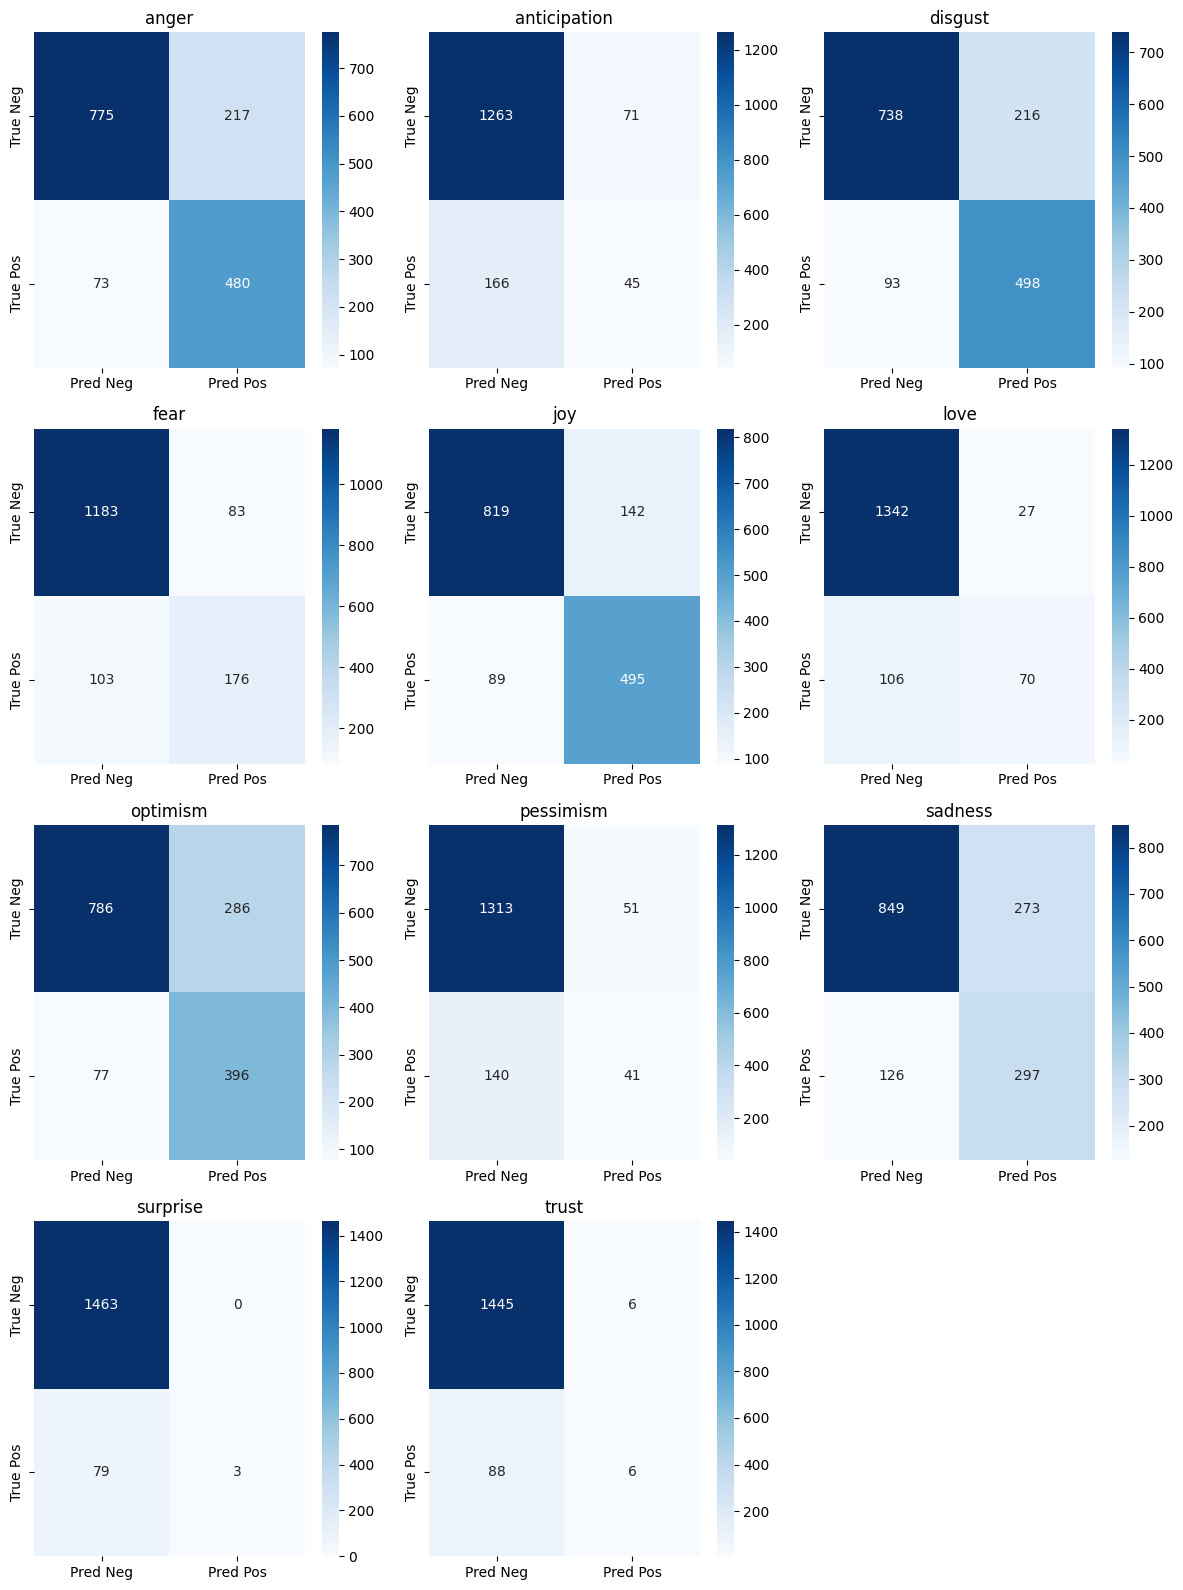

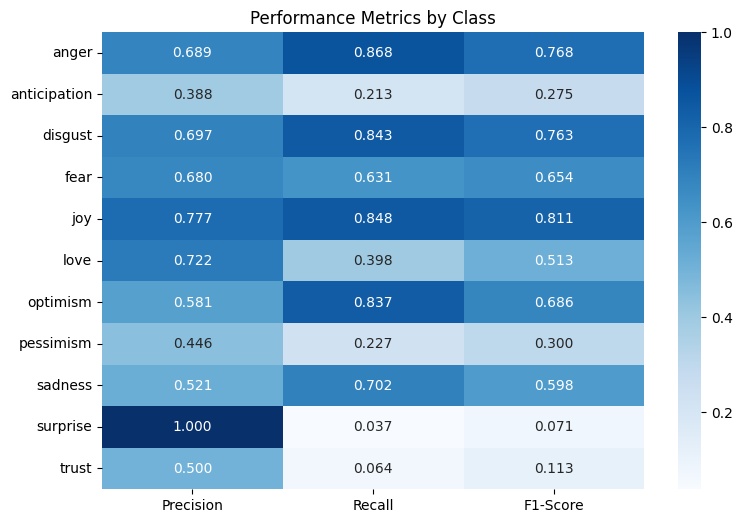

<Figure size 1200x533.333 with 0 Axes>

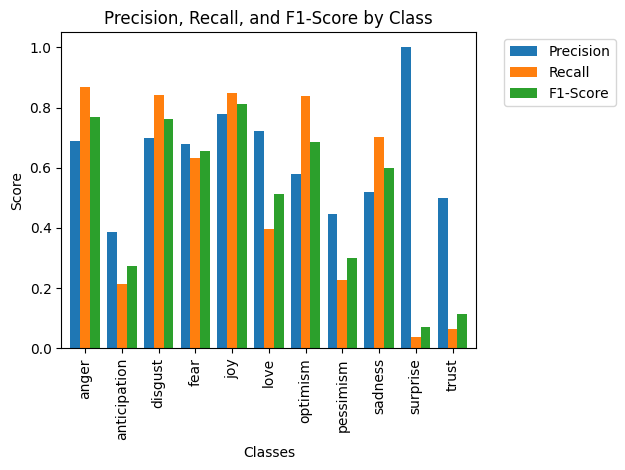

{'macro_avg': {'precision': 0.6363356299923031,
  'recall': 0.5151207581848317,
  'f1': 0.5047652586266956},
 'per_class': {'Precision': {'anger': 0.6886657101865137,
   'anticipation': 0.3879310344827586,
   'disgust': 0.6974789915966386,
   'fear': 0.6795366795366795,
   'joy': 0.7770800627943485,
   'love': 0.7216494845360825,
   'optimism': 0.5806451612903226,
   'pessimism': 0.44565217391304346,
   'sadness': 0.5210526315789473,
   'surprise': 1.0,
   'trust': 0.5},
  'Recall': {'anger': 0.8679927667269439,
   'anticipation': 0.2132701421800948,
   'disgust': 0.8426395939086294,
   'fear': 0.6308243727598566,
   'joy': 0.8476027397260274,
   'love': 0.3977272727272727,
   'optimism': 0.8372093023255814,
   'pessimism': 0.2265193370165746,
   'sadness': 0.7021276595744681,
   'surprise': 0.036585365853658534,
   'trust': 0.06382978723404255},
  'F1-Score': {'anger': 0.768,
   'anticipation': 0.27522935779816515,
   'disgust': 0.7632183908045977,
   'fear': 0.654275092936803,
   'jo

In [ ]:
multilabel_evaluation(y_true=valid_labels_binary, y_pred=valid_predictions_binary, class_names=class_names, figsize=(12, 8))

In [ ]:
test_dataset = data_folder/'test.csv'

In [ ]:
test_dataset = load_dataset('csv', data_files={'test': str(data_folder / 'test.csv')})['test']

In [ ]:
test_dataset

Dataset({
    features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
    num_rows: 3259
})

In [ ]:
# Select only the 'Tweet' column and rename it to 'text'
test_set = test_dataset.map(lambda x: {"text": x["Tweet"]}, remove_columns=test_dataset.column_names)

# Verify the updated dataset
print(test_dataset)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

Dataset({
    features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
    num_rows: 3259
})


In [ ]:
test_set['text'][1]

'Academy of Sciences, eschews the normally sober tone of scientific papers and calls the massive loss of wildlife a “biological annihilation'

In [ ]:
test_set = test_set.map(format_chat_inference)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
test_inference_results = run_inference_instruction(seed = 42,
              dataset=test_set,
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=50,
              input_field='text',
              output_field='label',
              save_dir=model_folder,
              save_file_name = 'test_complete_generations')

Generating predictions: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Saved inference_results to: /content/drive/MyDrive/Data/Models/Emotion_detection_Qwen_instruct_fall_2024/test_complete_generations.json


In [ ]:
test_inference_results[1]['generated_output']

"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: Academy of Sciences, eschews the normally sober tone of scientific papers and calls the massive loss of wildlife a “biological annihilation<|im_end|>\n<|im_start|>assistant\n['anger', 'disgust', 'sadness']<|im_end|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>"

In [ ]:
test_extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in test_inference_results]

In [ ]:
# Extract IDs from the test dataset
test_ids = test_dataset['ID']  # Replace 'ID' with the column name in your dataset that contains IDs

# Clean the extracted predictions to ensure proper formatting
cleaned_predictions = [eval(pred) if isinstance(pred, str) else pred for pred in test_extracted_outputs]

# Create a DataFrame with ID and Predicted Outputs
Output_df = pd.DataFrame({
    "ID": test_ids,
    "Predicted Outputs": cleaned_predictions
})

# Display the DataFrame
print(Output_df.head())

           ID           Predicted Outputs
0  2018-01559      [anger, disgust, fear]
1  2018-03739   [anger, disgust, sadness]
2  2018-00385   [anger, disgust, sadness]
3  2018-03001   [anger, disgust, sadness]
4  2018-01988  [fear, pessimism, sadness]


In [ ]:
# Define all possible emotion labels
all_labels = ["anger", "anticipation", "disgust", "fear", "joy", "love",
              "optimism", "pessimism", "sadness", "surprise", "trust"]

# Ensure that 'Predicted Outputs' is not None and is a list before processing
for label in all_labels:
    Output_df[label] = Output_df["Predicted Outputs"].apply(
        lambda x: 1 if isinstance(x, list) and label in x else 0
    )

# Optionally drop the "Predicted Outputs" column if not needed
Output_df = Output_df.drop(columns=["Predicted Outputs"])

# Save the resulting DataFrame to a new CSV file
output_binary_file = "test_predictions_qwen_0.5b_Inst.csv"
Output_df.to_csv(output_binary_file, index=False)
print(f"Predictions saved to {output_binary_file}")

# Display the DataFrame
print(Output_df.head())

Predictions saved to test_predictions_qwen_0.5b_Inst.csv
           ID  anger  anticipation  disgust  fear  joy  love  optimism  \
0  2018-01559      1             0        1     1    0     0         0   
1  2018-03739      1             0        1     0    0     0         0   
2  2018-00385      1             0        1     0    0     0         0   
3  2018-03001      1             0        1     0    0     0         0   
4  2018-01988      0             0        0     1    0     0         0   

   pessimism  sadness  surprise  trust  
0          0        0         0      0  
1          0        1         0      0  
2          0        1         0      0  
3          0        1         0      0  
4          1        1         0      0  
